In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import datasets,tree
from sklearn.tree import export_graphviz 
from sklearn import externals
from io import StringIO
import pydotplus
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt

## __1 - Business Problem__  
___Use Random Forest to prepare a model on fraud data___  

## __2 - Data collection and description__ 

In [24]:
df = pd.read_csv("Fraud_check (1).csv")

In [25]:
df1 = df.copy()

In [26]:
df1.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [27]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Taxable.Income,600.0,55208.375000,26204.827597,10003.0,32871.50,55074.5,78611.75,99619.0
City.Population,600.0,108747.368333,49850.075134,25779.0,66966.75,106493.5,150114.25,199778.0
Work.Experience,600.0,15.558333,8.842147,0.0,8.00,15.0,24.00,30.0


In [28]:
df1.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [29]:
df1.dtypes

Undergrad          object
Marital.Status     object
Taxable.Income      int64
City.Population     int64
Work.Experience     int64
Urban              object
dtype: object

### Outlier Check

D:\ProgramFiles\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


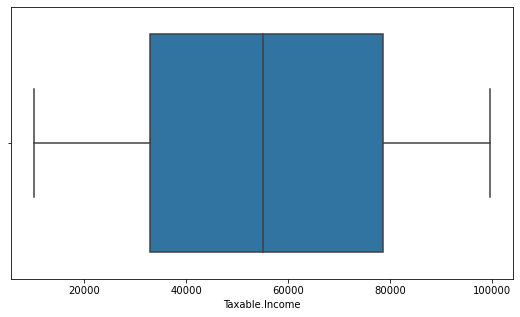

In [30]:
ax = sns.boxplot(df1['Taxable.Income'])

### There are no outliers in the data

In [31]:
plt.rcParams["figure.figsize"] = 9,5

Skew: 0.030014788906377175
Kurtosis: -1.1997824607083138


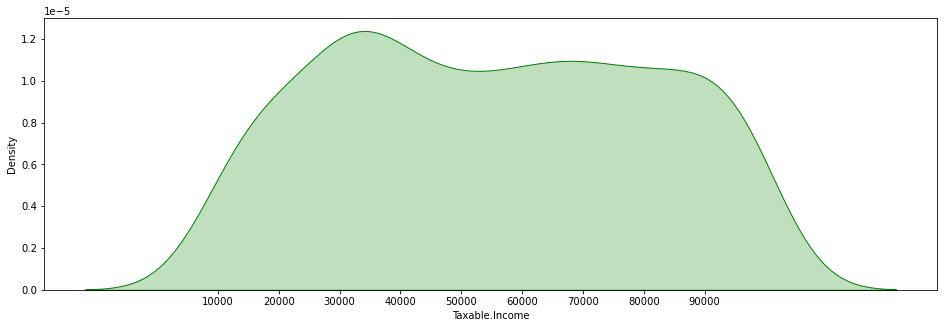

In [32]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df1['Taxable.Income'].skew()))
print("Kurtosis: {}".format(df1['Taxable.Income'].kurtosis()))
ax = sns.kdeplot(df1['Taxable.Income'],shade=True,color='g')
plt.xticks([i for i in range(10000,100000,10000)])
plt.show()

### The data is Skwed on the right  
### The data has negative Kurtosis

In [33]:
obj_colum = df1.select_dtypes(include='object').columns.tolist()

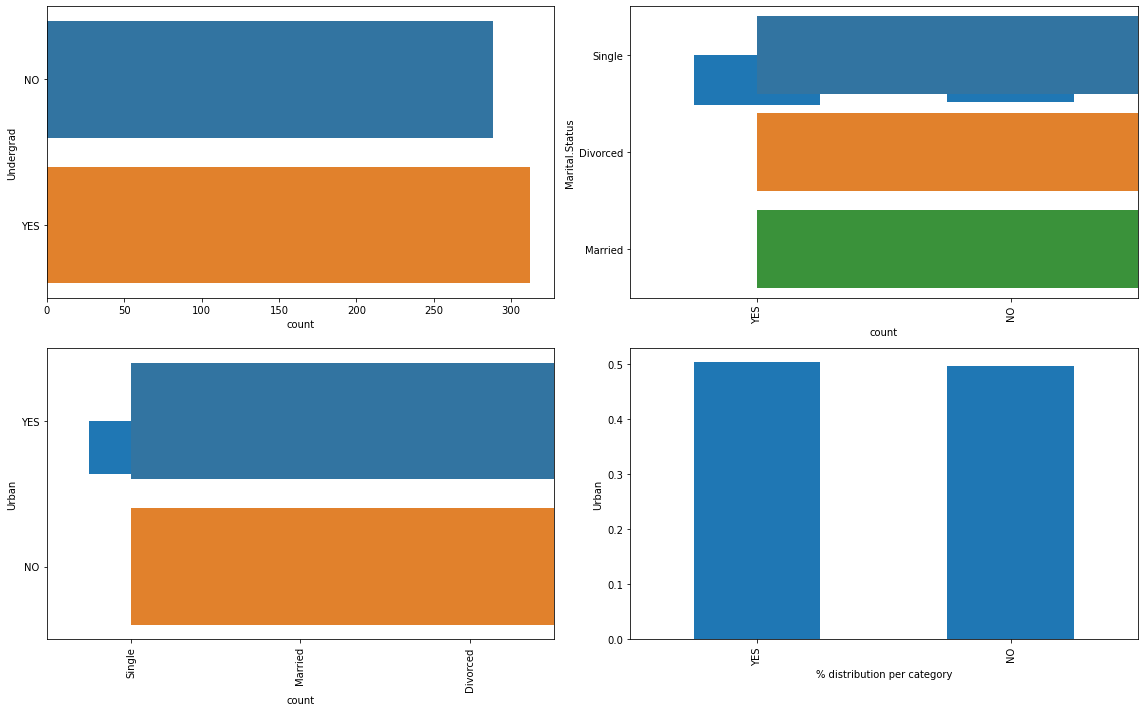

In [34]:
plt.figure(figsize=(16,10))
for i,col in enumerate(obj_colum,1):
    plt.subplot(2,2,i)
    sns.countplot(data=df1,y=col)
    plt.subplot(2,2,i+1)
    df1[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()  

In [35]:
num_columns = df1.select_dtypes(exclude='object').columns.tolist()

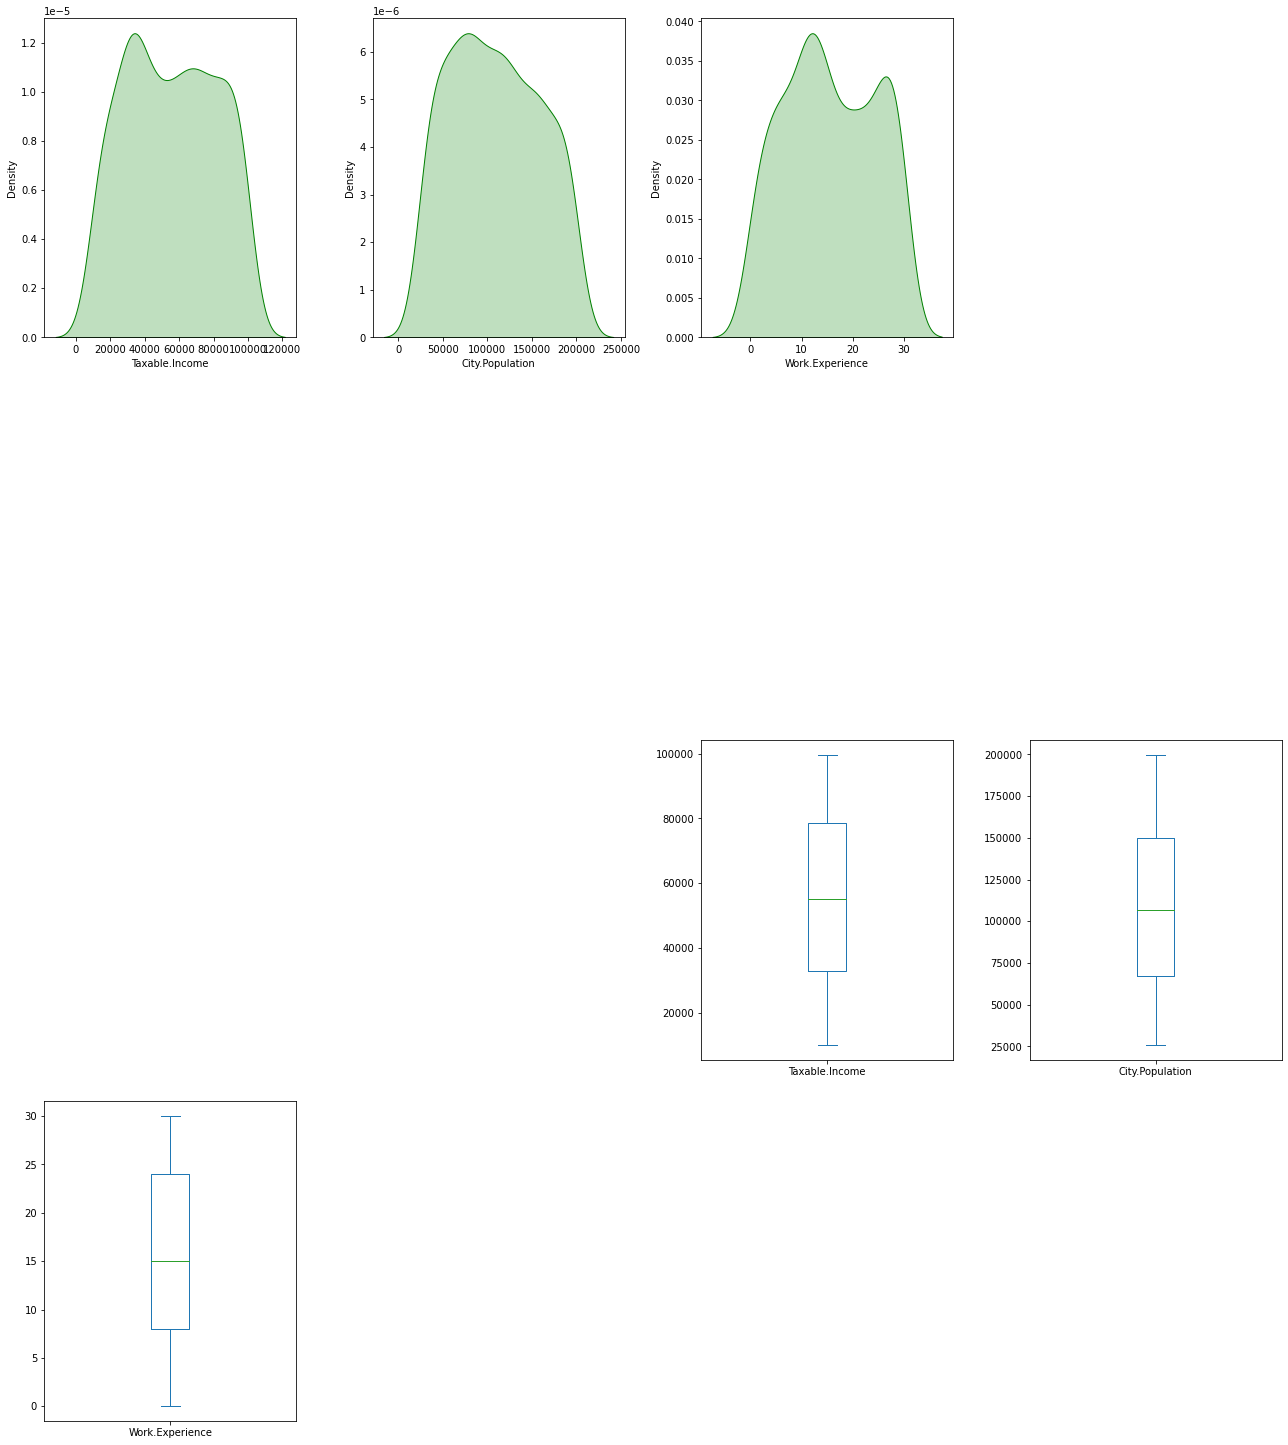

,Taxable.Income,City.Population,Work.Experience
skewness,0.030015,0.125009,0.018529
kurtosis,-1.199782,-1.120154,-1.167524


In [36]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

In [37]:
df1

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


In [38]:
df1 = pd.get_dummies(df1, columns = ['Undergrad','Marital.Status','Urban'])

In [39]:
corr = df1.corr()

In [40]:
corr = df1.corr()

<AxesSubplot:>

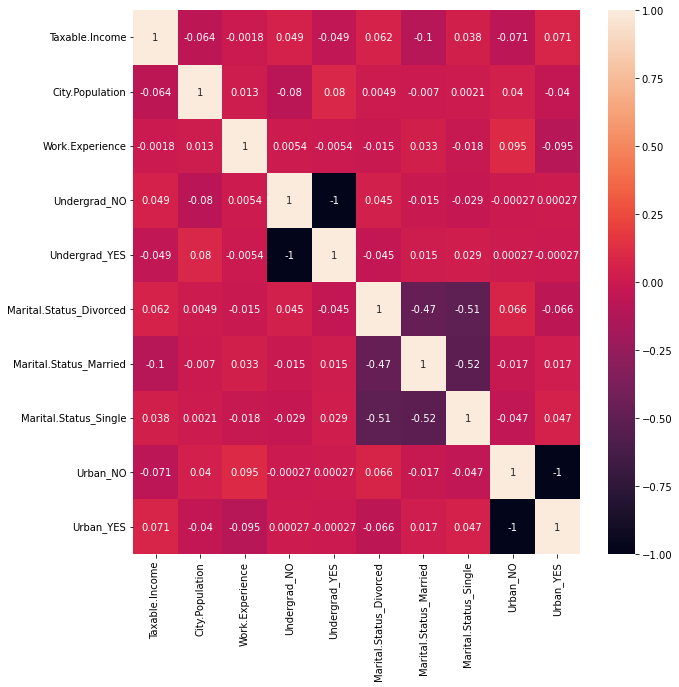

In [41]:
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True)

## __3 - Random Forest Model__ 

### Since the target variable is continious, we create a class of taxable_income <= 30000 as "Risky" and others are "Good"   

In [42]:
df1['Taxable.Income']=pd.cut(df1['Taxable.Income'],bins=[0,30000,100000],labels=['risky','good'])

In [43]:
list(df1.columns)

['Taxable.Income',
 'City.Population',
 'Work.Experience',
 'Undergrad_NO',
 'Undergrad_YES',
 'Marital.Status_Divorced',
 'Marital.Status_Married',
 'Marital.Status_Single',
 'Urban_NO',
 'Urban_YES']

In [44]:
X = df1.iloc[:,1:10]
y = df1.iloc[:,0]

In [45]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [46]:
y_train.value_counts()

good     380
risky    100
Name: Taxable.Income, dtype: int64

In [47]:
model =RF(n_jobs=4,n_estimators = 150, oob_score =True,criterion ='entropy') 
model.fit(x_train,y_train)
model.oob_score_

0.7520833333333333

In [48]:
pred_train = model.predict(x_train)

In [49]:
accuracy_score(y_train,pred_train)

1.0

In [50]:
confusion_matrix(y_train,pred_train)

array([[380,   0],
       [  0, 100]], dtype=int64)

In [51]:
pred_test = model.predict(x_test)

In [52]:
accuracy_score(y_test,pred_test)

0.7083333333333334

In [53]:
confusion_matrix(y_test,pred_test)

array([[85, 11],
       [24,  0]], dtype=int64)

In [54]:
df_t=pd.DataFrame({'Actual':y_test, 'Predicted':pred_test})

In [55]:
df_t

,Actual,Predicted
345,good,good
298,good,risky
414,good,good
337,risky,good
522,good,good
...,...,...
8,good,good
218,good,good
469,good,good
363,risky,good


In [56]:
cols = list(df1.columns)

In [57]:
predictors = cols[1:10]
target = cols[0]

In [58]:
tree1 = model.estimators_[20]

In [59]:
dot_data = StringIO()

## __4 - Conclusion__ 

### Since the accuracy of the Training set is 100% we test the accurancy on the test data which is 72%  
### As seen in the confusion matrix of Test data 94 instances are presdected correctly and 26 instances are not

In [63]:
rf_small = RF(n_estimators=10, max_depth = 3)

In [64]:
rf_small.fit(x_train,y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [65]:
tree_small = rf_small.estimators_[5]

In [69]:
model.feature_importances_

array([0.51492007, 0.36074626, 0.01696313, 0.01569191, 0.0169055 ,
       0.0174839 , 0.01896374, 0.0186837 , 0.01964179])

In [70]:
fi = pd.DataFrame({'feature': list(x_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

In [71]:
fi

,feature,importance
0,City.Population,0.514920
1,Work.Experience,0.360746
8,Urban_YES,0.019642
6,Marital.Status_Single,0.018964
7,Urban_NO,0.018684
5,Marital.Status_Married,0.017484
2,Undergrad_NO,0.016963
4,Marital.Status_Divorced,0.016906
3,Undergrad_YES,0.015692


### As seen in the above table city population is most important feature